In [1]:
from datetime import datetime

from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.visualization import hist

from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [2]:
rootdir = Path("./data")
# use find to make this csv list
with open(rootdir / "2024_q1.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [3]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,17848,1,binospec,17848
f5,94,1,f5,94
mmirs,747,1,mmirs,747


In [4]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
fixed = data[np.isfinite(data['seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.]
fixed = fixed[fixed['seeing'] < 4.]
#fixed = fixed[fixed['time'] < "2020-12-31"]

In [5]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,focerr,cc_x_err,cc_y_err,xcen,ycen,seeing,raw_seeing,fwhm,wavefront_rms,residual_rms
0,2024-01-01T01:26:46.639000,f5,f5wfs_20231231-182659.fits,10.0,1.0148,49.247566,80.192147,3.5,3.49,3.8,...,-70.72,20.236,3.802,287.001228,237.002808,1.629141,1.643565,9.188263,1856.060518,1667.741712
1,2024-01-01T01:27:23.161000,f5,f5wfs_20231231-182735.fits,10.0,1.0145,48.832940,80.288824,3.6,3.50,3.8,...,5.03,0.000,1.674,289.993315,239.001851,1.220903,1.231494,7.334770,539.693384,1396.858039
2,2024-01-01T01:27:57.174000,f5,f5wfs_20231231-182809.fits,10.0,1.0143,48.441938,80.377670,3.5,3.50,3.7,...,0.00,-0.000,-0.000,292.001083,239.003333,1.546204,1.559433,8.814737,354.992354,1465.254432
3,2024-01-01T02:31:15.867000,f5,f5wfs_20231231-193133.fits,15.0,2.3422,53.693660,25.273554,2.4,2.42,2.6,...,24.43,2.695,-1.570,235.999528,230.997048,1.265634,2.109028,11.213741,1032.463829,1578.922050
5,2024-01-01T02:32:44.868000,f5,f5wfs_20231231-193302.fits,15.0,2.3204,53.800069,25.528643,2.3,2.45,2.7,...,-0.57,-0.000,2.649,237.000004,229.999541,1.234328,2.045354,10.940516,283.776660,1770.282615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,2024-03-28T12:02:06,mmirs,mmirs_wfs_0292.fits,30.0,1.2844,319.173810,51.131668,5.2,6.09,5.6,...,-17.82,-0.358,1.182,288.004104,228.993082,1.391369,1.616823,6.186550,608.960274,1813.611836
288,2024-03-28T12:02:39,mmirs,mmirs_wfs_0293.fits,30.0,1.2858,319.136742,51.054141,5.2,6.10,5.6,...,-9.10,-0.317,-0.161,288.983081,239.998464,1.456376,1.693470,6.405565,508.026586,1955.391281
289,2024-03-28T12:03:12,mmirs,mmirs_wfs_0294.fits,30.0,1.2872,319.100028,50.976347,5.2,6.14,5.6,...,-10.12,-1.659,-0.018,288.995189,239.996919,1.484997,1.727878,6.503605,512.122804,1800.961522
290,2024-03-28T12:03:45,mmirs,mmirs_wfs_0295.fits,30.0,1.2886,319.064773,50.901052,5.2,6.16,5.7,...,-6.72,0.000,0.000,288.995583,240.004009,1.455331,1.694466,6.408404,435.333208,1667.087337


In [6]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

<Figure size 800x500 with 0 Axes>

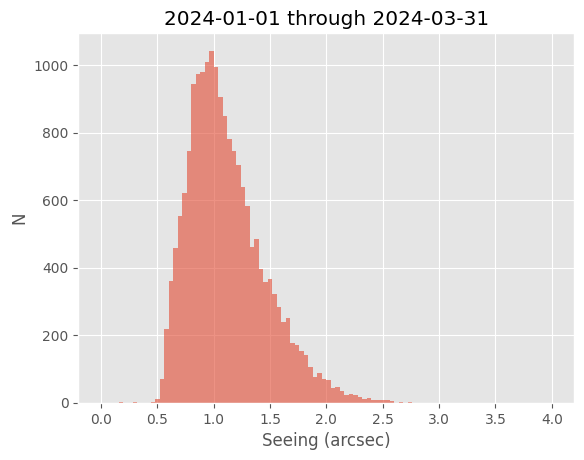

In [8]:
# make raw histogram of the zenith-corrected seeing column
fig = plt.figure(figsize=(8, 5))
fixed.hist(column='seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
with plt.style.context('ggplot'):
    plt.title("2024-01-01 through 2024-03-31")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.show()

In [9]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(fixed['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['seeing'])
fit_median = exp_mu + loc

0.3365966140234972 0.13110310534809627 0.9322749295745579


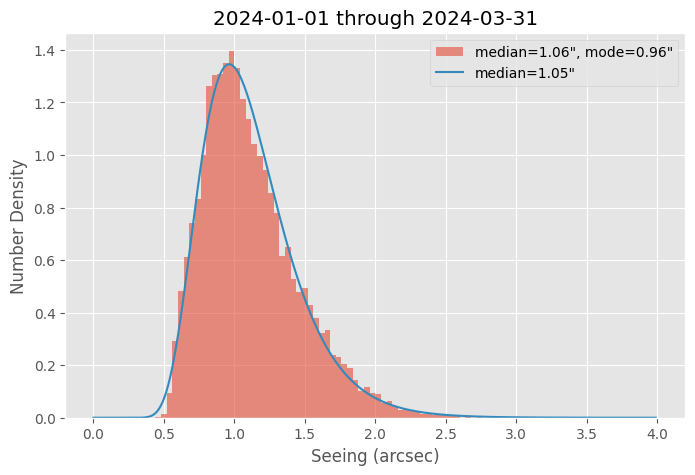

In [10]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("2024-01-01 through 2024-03-31")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig("2024_q1.png")
plt.show()

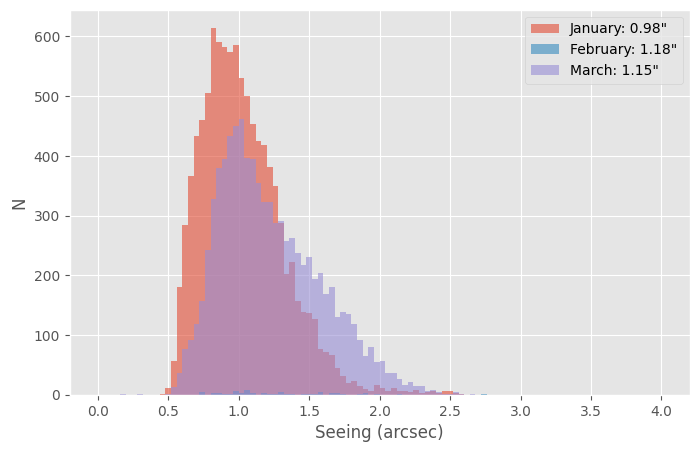

In [11]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
months = {}
legends = []
months['January'] = fixed.loc['2024-01']
months['February'] = fixed.loc['2024-02']
months['March'] = fixed.loc['2024-03']

for m in months:
    plt.hist(months[m]['seeing'], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]['seeing']))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig("2024_q1_monthly.png")
plt.show()

In [12]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

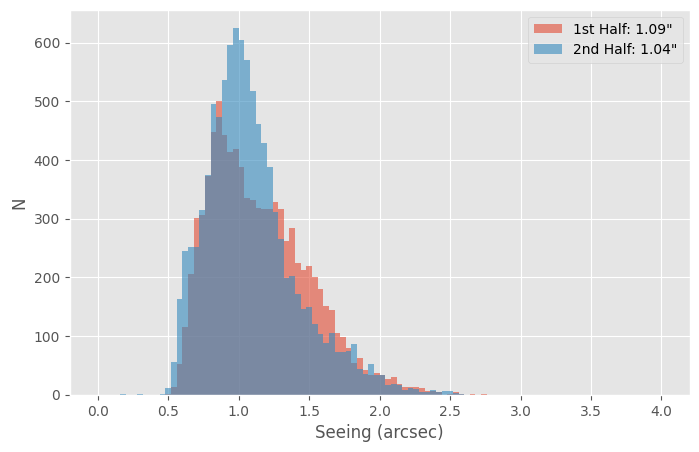

In [13]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("2024_q1_1st2nd.png")
plt.show()

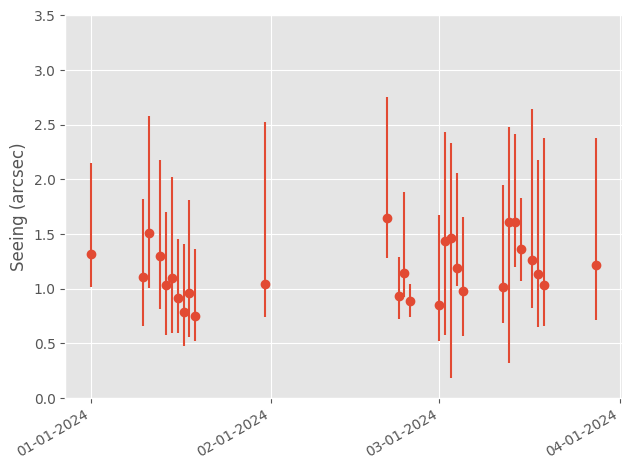

In [14]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.seeing.resample('D').median()
daily['max'] = fixed.seeing.resample('D').max()
daily['min'] = fixed.seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.set_ylim(0.0, 3.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("2024_q1_nightly.png")
plt.show()

In [15]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(fixed.loc[date]['seeing']) for date in date_list]
clean_data = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

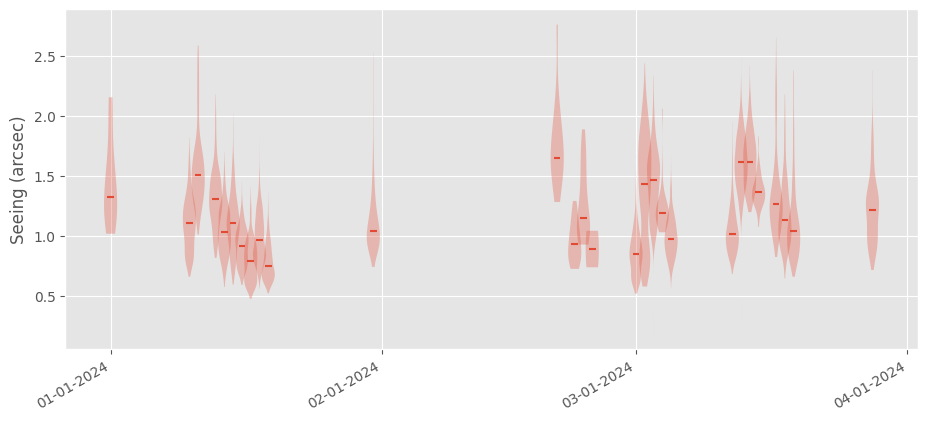

In [16]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2024_q1_violin.png")
    plt.show()

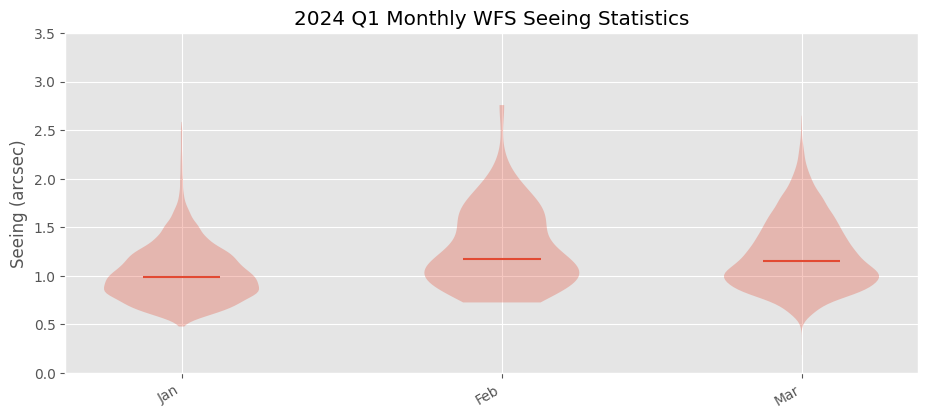

In [17]:
months = sorted(list(set(daily.index.strftime('%Y-%m'))))
mdata = [np.array(fixed.loc[month]['seeing']) for month in months]
clean_data = {}
for d, arr in zip(months, mdata):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=100, widths=15,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2024_q1_violin_monthly.png")
    plt.title("2024 Q1 Monthly WFS Seeing Statistics")
    plt.show()

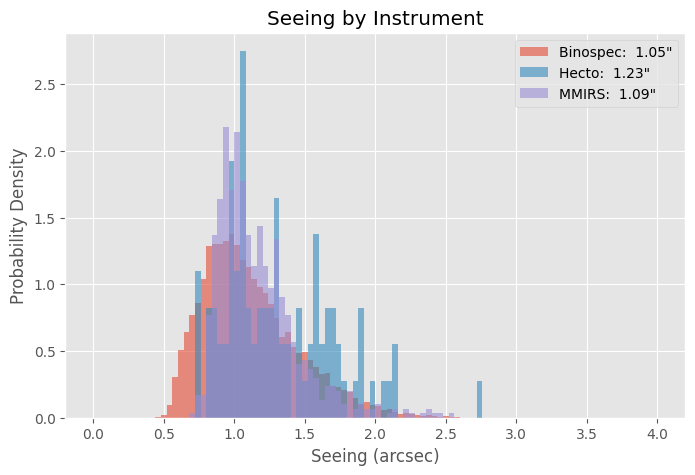

In [18]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    medb = np.median(fixed['seeing'][fixed['wfs'] == 'binospec'])
    medf = np.median(fixed['seeing'][fixed['wfs'] == 'f5'])
    medm = np.median(fixed['seeing'][fixed['wfs'] == 'mmirs'])
    plt.hist(fixed['seeing'][fixed['wfs'] == 'binospec'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Binospec: {medb: .2f}\"")
    plt.hist(fixed['seeing'][fixed['wfs'] == 'f5'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Hecto: {medf: .2f}\"")
    plt.hist(fixed['seeing'][fixed['wfs'] == 'mmirs'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"MMIRS: {medm: .2f}\"")
    plt.legend()
    plt.title("Seeing by Instrument")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Probability Density")
plt.savefig("per_instrument_2024_q1.png")
plt.show()

In [19]:
from minicyclop.io import read_seeing_data

In [20]:
cyclop = read_seeing_data(Path.home() / "MMT/minicyclop/data/MiniCyclop/Data/Seeing_Data.txt")

In [21]:
cyclop

,UT,flux,seeing,r0,isot,epoch_ms
ut,,,,,,
2022-06-08 03:32:32,6/8/2022 3:32:32 AM,2733.7,0.84,135.8,2022-06-08T03:32:32.968,1654659152968
2022-06-08 03:33:27,6/8/2022 3:33:27 AM,2755.7,0.84,134.4,2022-06-08T03:33:27.409,1654659207408
2022-06-08 03:34:23,6/8/2022 3:34:23 AM,2801.6,2.38,47.7,2022-06-08T03:34:23.655,1654659263655
2022-06-08 03:35:16,6/8/2022 3:35:16 AM,2853.2,1.01,112.3,2022-06-08T03:35:16.325,1654659316324
2022-06-08 03:36:00,6/8/2022 3:36:00 AM,2739.0,1.03,110.7,2022-06-08T03:36:00.691,1654659360691
...,...,...,...,...,...,...
2024-04-22 12:22:46,4/22/2024 12:22:46 PM,1695.6,0.90,126.0,2024-04-22T12:22:46.105,1713788566104
2024-04-22 12:23:34,4/22/2024 12:23:34 PM,1714.0,0.99,114.3,2024-04-22T12:23:34.498,1713788614497
2024-04-22 12:24:22,4/22/2024 12:24:22 PM,1698.4,0.78,145.9,2024-04-22T12:24:22.493,1713788662492


In [22]:
cyclop_q1 = cyclop[(cyclop.index >= '2024-01-01') & (cyclop.index < '2024-04-01')]

0.5316336150671036 0.3664177051026147 0.678161379492356


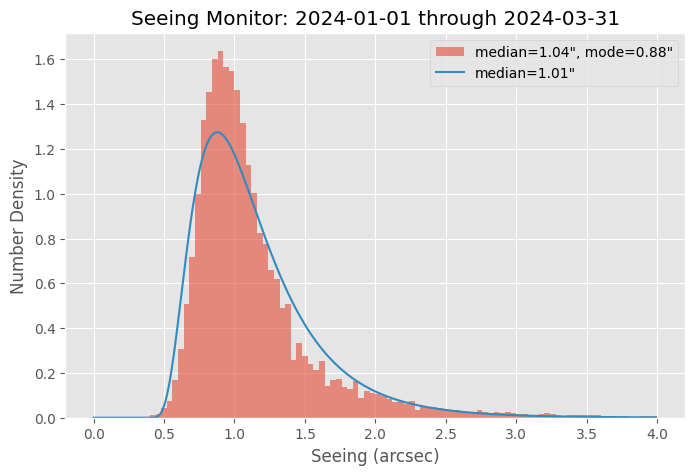

In [23]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(cyclop_q1['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(cyclop_q1['seeing'])
fit_median = exp_mu + loc

# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(cyclop_q1['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("Seeing Monitor: 2024-01-01 through 2024-03-31")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig("2024_q1_cyclop_hist.png")
plt.show()

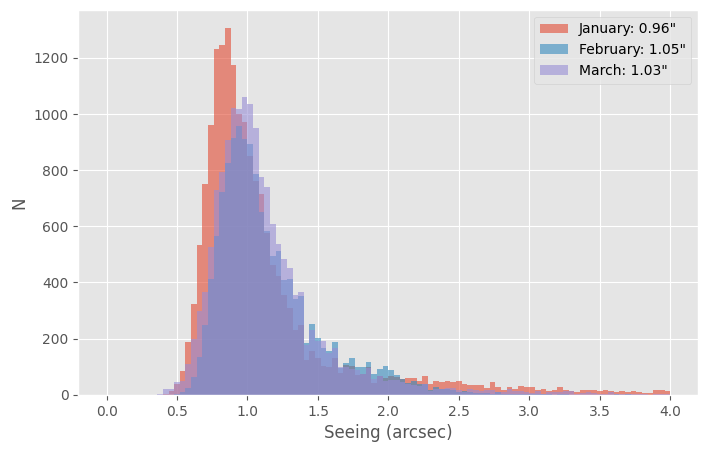

In [26]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
cyc_months = {}
legends = []
cyc_months['January'] = cyclop_q1.loc['2024-01']
cyc_months['February'] = cyclop_q1.loc['2024-02']
cyc_months['March'] = cyclop_q1.loc['2024-03']

for m in cyc_months.keys():
    plt.hist(cyc_months[m]['seeing'], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(cyc_months[m]['seeing']))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig("2024_q1_cyclop_monthly.png")
plt.show()

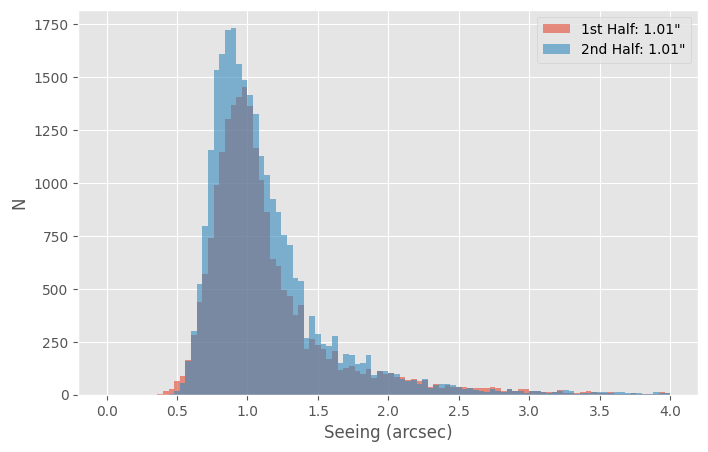

In [27]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = cyclop_q1.between_time(start_time='00:00', end_time='07:00')
second_half = cyclop_q1.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("2024_q1_cyclop_1st2nd.png")
plt.show()

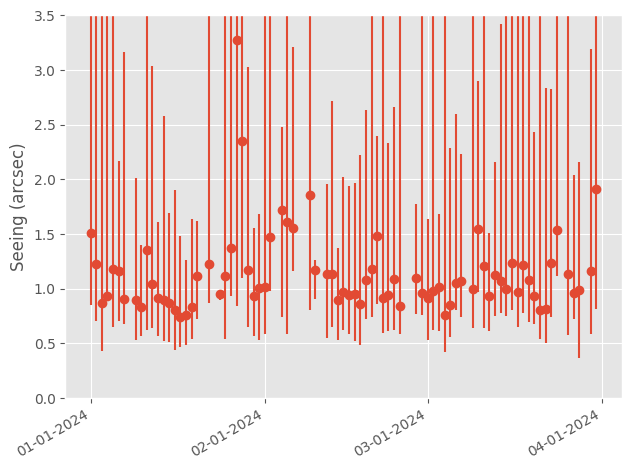

In [28]:
# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = cyclop_q1.seeing.resample('D').median()
daily['max'] = cyclop_q1.seeing.resample('D').max()
daily['min'] = cyclop_q1.seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.set_ylim(0.0, 3.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("2024_q1_cyclop_plot_monthly.png")
plt.show()

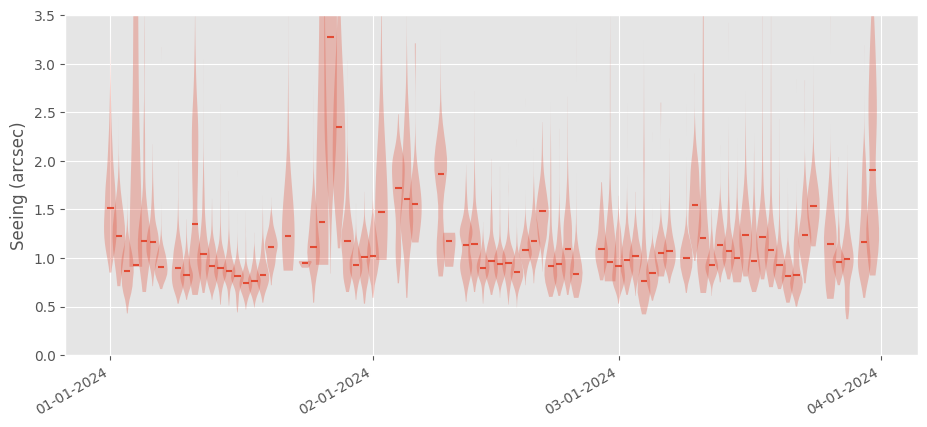

In [29]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(cyclop_q1.loc[date]['seeing']) for date in date_list]
clean_data = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2024_q1_cyclop_violin.png")
    plt.show()

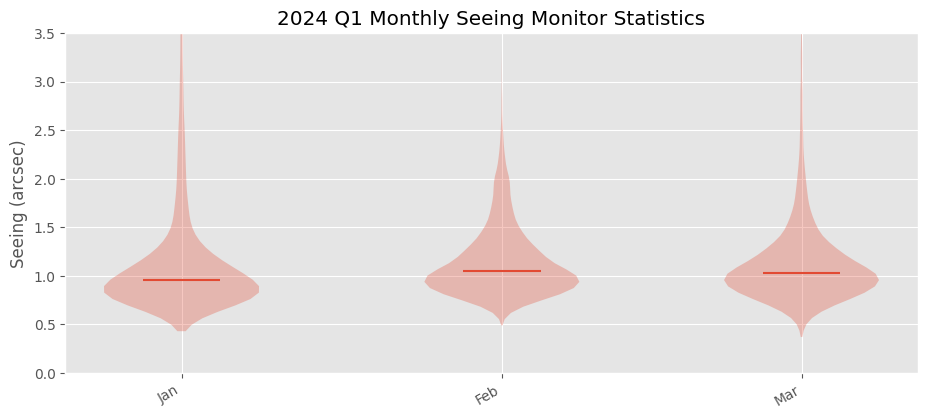

In [30]:
months = sorted(list(set(daily.index.strftime('%Y-%m'))))
mdata = [np.array(cyclop_q1.loc[month]['seeing']) for month in months]
clean_data = {}
for d, arr in zip(months, mdata):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=100, widths=15,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2024_q1_cyclop_violin_monthly.png")
    plt.title("2024 Q1 Monthly Seeing Monitor Statistics")
    plt.show()

In [31]:
bino = fixed[fixed['wfs'] == 'binospec']
hecto = fixed[fixed['wfs'] == 'f5']
mmirs = fixed[fixed['wfs'] == 'mmirs']

In [32]:
bino_dates = sorted(list(set(bino.index.strftime('%Y-%m-%d'))))
hecto_dates = sorted(list(set(hecto.index.strftime('%Y-%m-%d'))))
mmirs_dates = sorted(list(set(mmirs.index.strftime('%Y-%m-%d'))))
bino_dates, hecto_dates, mmirs_dates

(['2024-01-10',
  '2024-01-11',
  '2024-01-13',
  '2024-01-14',
  '2024-01-15',
  '2024-01-16',
  '2024-01-17',
  '2024-01-18',
  '2024-01-19',
  '2024-03-01',
  '2024-03-02',
  '2024-03-03',
  '2024-03-04',
  '2024-03-05',
  '2024-03-12',
  '2024-03-13',
  '2024-03-14',
  '2024-03-15',
  '2024-03-17',
  '2024-03-18',
  '2024-03-19'],
 ['2024-01-01', '2024-02-21', '2024-02-23', '2024-02-24', '2024-02-25'],
 ['2024-01-31', '2024-03-28'])

In [33]:
cyc_bino = np.hstack([np.array(cyclop_q1.loc[date]['seeing']) for date in bino_dates])
cyc_hecto = np.hstack([np.array(cyclop_q1.loc[date]['seeing']) for date in hecto_dates])
cyc_mmirs = np.hstack([np.array(cyclop_q1.loc[date]['seeing']) for date in mmirs_dates])

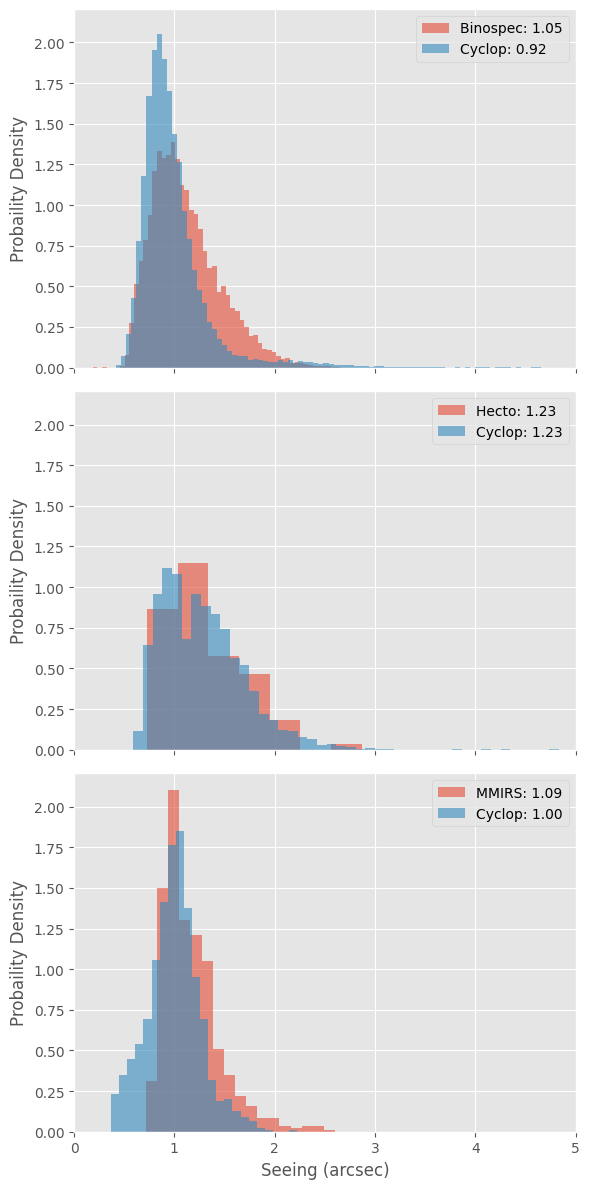

In [40]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(3, 1, figsize=(6, 12), sharex=True, sharey=True)
    ax = ax.flat
    fig.subplots_adjust(hspace=0)

    hist(bino['seeing'], bins='scott', ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_bino, bins='scott', ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    ax[0].legend([f"Binospec: {np.median(bino['seeing']):.2f}", f"Cyclop: {np.median(cyc_bino):.2f}"])
    ax[0].set_ylabel("Probaility Density")
    ax[0].set_xlim(0, 5)

    hist(hecto['seeing'], bins='scott', ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_hecto, bins='scott', ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    ax[1].legend([f"Hecto: {np.median(hecto['seeing']):.2f}", f"Cyclop: {np.median(cyc_hecto):.2f}"])
    ax[1].set_ylabel("Probaility Density")
    ax[1].set_xlim(0, 5)

    hist(mmirs['seeing'], bins='scott', ax=ax[2], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_mmirs, bins='scott', ax=ax[2], histtype='stepfilled', alpha=0.6, density=True)
    ax[2].legend([f"MMIRS: {np.median(mmirs['seeing']):.2f}", f"Cyclop: {np.median(cyc_mmirs):.2f}"])
    ax[2].set_xlim(0, 5)
    ax[2].set_xlabel("Seeing (arcsec)")
    ax[2].set_ylabel("Probaility Density")

    plt.tight_layout()
    plt.savefig("2024_q1_cyclop_vs_inst.png")
    plt.show()

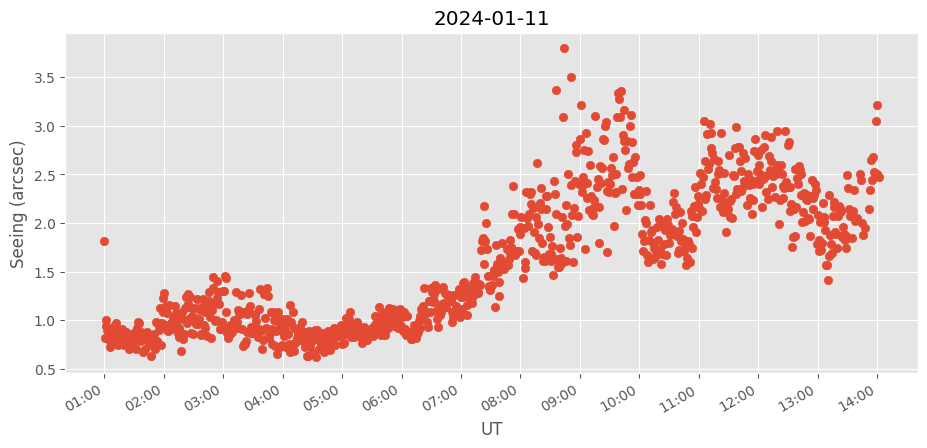

In [100]:
date = '2024-01-11'
night = cyclop_q1.loc[date]
fig, ax = plt.subplots(figsize=(11,5))
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
fig.autofmt_xdate()
plt.scatter(night.index, night['seeing'])
plt.ylabel("Seeing (arcsec)")
plt.title(date)
plt.xlabel("UT")
plt.show()